# Cuda-vision Lab - Assignment 1
##     Mst.Mahfuja Akter

In [26]:
# only for the load_mnist function
import os, struct
from array import array as pyarray
from numpy import  array, zeros
# general import
import numpy as np
from matplotlib import pyplot as plt

In [27]:
#defining softmax function as activation function
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [28]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

We got provided this function in the lecture "Deep Learning for visual recognition".
It reads and open the data according to following structere:

# TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
|   [offset]   |   [type]     |     [value]   |     [description]   |
|-|-|-|-|
|0000   |  32 bit integer | 0x00000801(2049)| magic number (MSB first)|
|0004  |   32 bit integer | 60000        |    number of items|
|0008  |   unsigned byte  | ??           |    label   |
|0009   |  unsigned byte |  ??          |     label   |
||........||
|xxxx   |  unsigned byte  | ??           |    label

The labels values are 0 to 9.
# TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
|   [offset]   |   [type]     |     [value]   |     [description]   |
|-|-|-|-|
|0000  |   32 bit integer | 0x00000803(2051)| magic number|
0004   |  32 bit integer | 60000           | number of images|
0008   |  32 bit integer | 28       |        number of rows|
0012    | 32 bit integer | 28        |       number of columns|
0016   |  unsigned byte |  ??       |        pixel|
0017   |  unsigned byte |  ??   |           pixel|
||........||
|xxxx  |   unsigned byte |  ??        |       pixel|

Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).
# TEST SET LABEL FILE (t10k-labels-idx1-ubyte):
|   [offset]   |   [type]     |     [value]   |     [description]   |
|-|-|-|-|
|0000  |   32 bit integer | 0x00000801(2049)| magic number (MSB first)|
|0004  |   32 bit integer | 10000      |      number of items|
|0008   |  unsigned byte |  ??         |      label|
|0009  |   unsigned byte |  ??         |      label|
||........||
|xxxx   |  unsigned byte  | ??         |      label|

The labels values are 0 to 9.
# TEST SET IMAGE FILE (t10k-images-idx3-ubyte):
|   [offset]   |   [type]     |     [value]   |     [description]   |
|-|-|-|-|
|0000   |  32 bit integer|  0x00000803(2051)| magic number|
|0004   |  32 bit integer | 10000    |        number of images|
|0008   |  32 bit integer|  28      |         number of rows|
|0012   |  32 bit integer|  28      |         number of columns|
|0016   |  unsigned byte|  ??      |         pixel|
|0017    | unsigned byte |  ??      |         pixel|
||........||
|xxxx   |  unsigned byte |  ??      |         pixel|

In [29]:
def load_mnist(dataset="training", digits=np.arange(10), path="."):
    """
    Loads MNIST files into 3D numpy arrays 
    Adapted from: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
    """
    
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    
    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = np.zeros((N, rows, cols) )
    labels = np.zeros((N ) )
    for i in range(len(ind)):
        images[i] = np.array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]

    return images, labels

In [30]:
np.random.seed(0)

Now we can load the MNIST data set and use load_mnist function to load the raw data and also process it into manageable chunks.<br>
Our path is: data/MNIST/raw/

In [31]:
path = input("Please enter the path for training data starting from the executed ipynb file:")
train_data, train_label = load_mnist("training",path=path)
path = input("Please enter the path for test data starting from the executed ipynb file:")
test_data, test_label = load_mnist("testing",path=path)

Please enter the path for training data starting from the executed ipynb file:C:\Users\user\Documents\CudaLab\Assignment1
Please enter the path for test data starting from the executed ipynb file:C:\Users\user\Documents\CudaLab\Assignment1


In [32]:
# Reshape the image data into rows
image_vector_size = 28*28
train_data = train_data.reshape(train_data.shape[0], image_vector_size)
test_data = test_data.reshape(test_data.shape[0], image_vector_size)
# Change to float datatype
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
 
# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

In [33]:
def one_hot_classification_converter(data,classes):
    num_classes = len(classes)
    representation = np.zeros((len(data),num_classes))
    for ele,ind in zip(data,range(len(data))):
        representation[ind][int(ele)] = 1
    return representation

In [34]:
num_classes = 10
image_size = 784 #28x28
batch_size = 20
# Change the labels from integer to categorical data
lr = np.arange(num_classes)
# transform labels into one hot representation
y_train_one_hot = one_hot_classification_converter(train_label,lr).astype(int)
y_test_one_hot =  one_hot_classification_converter(test_label,lr).astype(int)


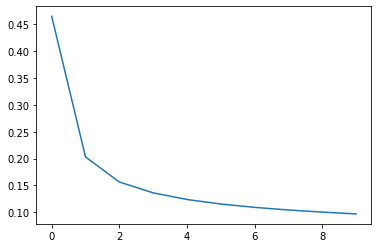

In [35]:
#2 layer Neural network code 
#initialize random seed


#Weight matrix of size 784x10
W = np.random.normal(size=(image_size,num_classes))
bias = np.zeros(num_classes)
learnrate = 0.01
error = []
final_error = []
epoches = 10
for e in range(epoches):
    # each epoche randomly shuffle the data 
    tmp_shuffler = np.arange(len(train_label))
    train_data = train_data[tmp_shuffler]
    train_label = train_label[tmp_shuffler]
    y_train_one_hot = y_train_one_hot[tmp_shuffler]
    
    #defining a for loop from 1 to 60000 where the batch size is 20
    for i in range(1,60000,batch_size):
        layer_0 = train_data[i:i+batch_size,:]
        # check above 2 cells why we need a double transpose here
        layer_1 = np.transpose(softmax(np.transpose(np.dot(layer_0,W)+bias)))  
        # calculate (teacher-output) for whole batch
        absolute_error = np.subtract(y_train_one_hot[i:i+batch_size,:], layer_1)
        # calculate MSE
        batch_error = (0.5*np.square(absolute_error).sum())/batch_size
        #print("epoch:",e,";batch:",i," error:",batch_error)
        
        # calculate general delta rule
        delta = layer_1*(1-layer_1)*absolute_error
        W_change = learnrate*np.dot(np.transpose(layer_0),delta)
        W += W_change
        
        error.append(batch_error)
        
    final_error.append(np.mean(error))
    error.clear()
    
plt.plot(final_error)